In [2]:
import pickle
from functools import partial
from multiprocessing.pool import Pool
from pathlib import Path
from typing import Any, Callable, Optional

import darts
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from darts.dataprocessing.transformers import Scaler
from darts.models import AutoARIMA, NBEATSModel
from darts.models.forecasting.forecasting_model import ForecastingModel
from darts.timeseries import TimeSeries
from darts.utils.data import TrainingDataset
from darts.utils.missing_values import fill_missing_values
from sklearn.preprocessing import MinMaxScaler, StandardScaler

/home/konstantinos/miniconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/konstantinos/miniconda3/envs/thesis/lib/python3.10/site-packages/statsforecast/utils.py:236: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


## Data Loading

In [3]:
def load_electricity_consumption(
    file_path=Path("data", "LD2011_2014.txt"),
    freq="2H",
    start_time="2014-01-02 00:00:00",
    end_time="2014-09-01 00:00:00",
    components=[f"MT_{i:03}" for i in range(1, 51)],
) -> TimeSeries:
    df = pd.read_csv(file_path, sep=";", index_col=0, parse_dates=True, decimal=",")
    # df = df.replace(0, np.nan)

    df = df.loc[start_time:end_time, components]

    df = df.resample(freq).mean()

    ts = TimeSeries.from_dataframe(df, freq=freq)

    ts = ts.astype(np.dtype("float32"))

    return ts


ts = load_electricity_consumption()
# ts = fill_missing_values(ts, interpolate_kwargs=dict(method='time'))
assert not ts.pd_dataframe(copy=False).isna().any(axis=None)

/tmp/ipykernel_4267/549808843.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample(freq).mean()


## Splitting and Normalization

https://www.tensorflow.org/tutorials/structured_data/time_series#normalize_the_data

> It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.
>
> The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.
>
> It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity this tutorial uses a simple average.



In [4]:
# 70 - 10 - 10 split
ts_train_original, ts_nontrain_original = ts.split_before(0.8)
ts_val_original, ts_test_original = ts_nontrain_original.split_before(0.5)

In [5]:
# transformer = Scaler(MinMaxScaler())
transformer = Scaler(StandardScaler())


ts_train_transformed: TimeSeries = transformer.fit_transform(ts_train_original)  # type: ignore
ts_val_transformed: TimeSeries = transformer.transform(ts_val_original)  # type: ignore
ts_test_transformed: TimeSeries = transformer.transform(ts_test_original)  # type: ignore

## ARIMA Training

In [6]:
def separate(ts: TimeSeries) -> list[TimeSeries]:
    return [ts.univariate_component(i) for i in range(ts.n_components)]


def fit_univariate(
    data: TimeSeries,
    model_cls: type[ForecastingModel],
    model_cls_kwargs: Optional[dict[str, Any]] = None,
) -> ForecastingModel:
    if model_cls_kwargs is None:
        model_cls_kwargs = {}

    model = model_cls(**model_cls_kwargs)
    model.fit(data)

    return model

In [7]:
TH = 12*14
FH = 12*1

In [8]:
from darts.models import Prophet

In [9]:
fit_autoarima: Callable[[TimeSeries], AutoARIMA] = partial(fit_univariate, model_cls=Prophet)  # type: ignore

with Pool() as pool:
    res = pool.map(fit_autoarima, separate(ts_train_original))


# with open("arima_results.pkl", "wb") as f:
#     pickle.dump(res, f)

00:03:25 - cmdstanpy - INFO - Chain [1] start processing
00:03:25 - cmdstanpy - INFO - Chain [1] start processing
00:03:25 - cmdstanpy - INFO - Chain [1] start processing
00:03:25 - cmdstanpy - INFO - Chain [1] start processing
00:03:25 - cmdstanpy - INFO - Chain [1] start processing
00:03:25 - cmdstanpy - INFO - Chain [1] start processing
00:03:25 - cmdstanpy - INFO - Chain [1] start processing
00:03:25 - cmdstanpy - INFO - Chain [1] start processing
00:03:25 - cmdstanpy - INFO - Chain [1] start processing
00:03:25 - cmdstanpy - INFO - Chain [1] start processing
00:03:25 - cmdstanpy - INFO - Chain [1] start processing
00:03:25 - cmdstanpy - INFO - Chain [1] start processing
00:03:25 - cmdstanpy - INFO - Chain [1] start processing
00:03:25 - cmdstanpy - INFO - Chain [1] start processing
00:03:25 - cmdstanpy - INFO - Chain [1] start processing
00:03:25 - cmdstanpy - INFO - Chain [1] start processing
00:03:25 - cmdstanpy - INFO - Chain [1] done processing
00:03:26 - cmdstanpy - INFO - Ch

In [6]:
# with open("arima_results.pkl", "rb") as f:
#     res: list[AutoARIMA] = pickle.load(f)

In [10]:
res[1].model.summary()

AttributeError: 'Prophet' object has no attribute 'summary'

<Axes: xlabel='time'>

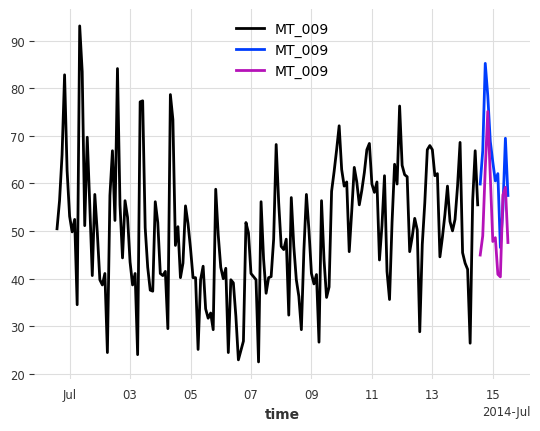

In [11]:
i = 8
n = 12
separate(ts_train_original)[i][-24*7:].plot()
separate(ts_val_original)[i][:n].plot()
res[i].predict(n).plot()


## Other

In [16]:
model = NBEATSModel(
    input_chunk_length=7 * 12,  # 7 days
    output_chunk_length=1 * 12,  # 1 day
    optimizer_kwargs=dict(
        lr=1e-3,
    ),
    pl_trainer_kwargs=dict(
        accelerator="gpu",
        devices=[0],
    ),
)

model.fit(
    series=ts_train_transformed,
    val_series=ts_val_transformed,
    epochs=10,
    num_loader_workers=2,
)

def fit(model_cls, model_params, data):
    model = model_cls(**model_params)
    model.fit(data)
    return model
    
    

In [66]:
preds = transformer.inverse_transform(
    model.predict(n=1 * 12, series=ts_test_transformed[: 7 * 12])
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.72it/s]


In [75]:
preds.end_time()

Timestamp('2014-08-15 16:00:00', freq='2H')

In [74]:
ts_test_original[7 * 12 : 8 * 12].end_time()

Timestamp('2014-08-15 16:00:00', freq='2H')